<a href="https://colab.research.google.com/github/mohammadrahmani98/C-path/blob/main/kalmanfilter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**STATISTICAL LEARNING AND NEURAL NETWORKS, A.A. 2022/2023**

**COMPUTER LAB 4** - Kalman filter

**Duration: 3 hours**

**Introduction:**

In this lab, you are provided with the set of coordinates (x,y – horizontal and vertical) describing the trajectories of pedestrians moving acrooss a scene. Your task is to simulate the observed positions of the pedestrians by adding observation noise, then to track the subjects using a Kalman filter. In other words, you need to estimate the next (x,y) positions, from the observations of the previous positions.


*Simulating the observed coordinates*

Choose one of the trajectories in the dataset. This data will be considered the real trajectory. Generate the observed directory by adding observation noise $\delta_t \sim\ \mathcal{N}(0,\sigma^{2}_{R})\$ to the (x,y) coordinates.


*Designing the Kalman filter*

Your task is to **design a Kalman filter** based on a constant velocity model, which tracks the next (x,y) position of the object, from the observation of the previous positions. The code must be based on the following model.

*   The state vector contains coordinates and velocities: $z^{T}_{t} = (z_{1t}, z_{2t}, v_{1t}, v_{2t})$ (see slides). The object has initial coordinates (0,0) and velocity $(\Delta,Δ)$.
*   Only the coordinates (but not the velocities) are observed. This leads to a linear dynamical system with:

$A = \left( \begin{matrix} 1 & 0 & \Delta & 0 \\ 0 & 1 & 0 & \Delta \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{matrix} \right)$


$C = \left( \begin{matrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \end{matrix} \right)$

and B = D = 0.

*   $\Sigma_{Q}$, and $\Sigma_{R}$ should be set to:

$\Sigma_{Q} = \sigma^{2}_{Q}\left( \begin{matrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{matrix} \right)$

$\Sigma_{R} = \sigma^{2}_{R}\left( \begin{matrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{matrix} \right)$

To see if your Kalman filter is working well, you should plot the estimated position of the object over time with respect to the true position (i.e., the first two entries of the state vector) and the observed position. Depending on the chosen parameters, for each coordinate the graph may look something like this:

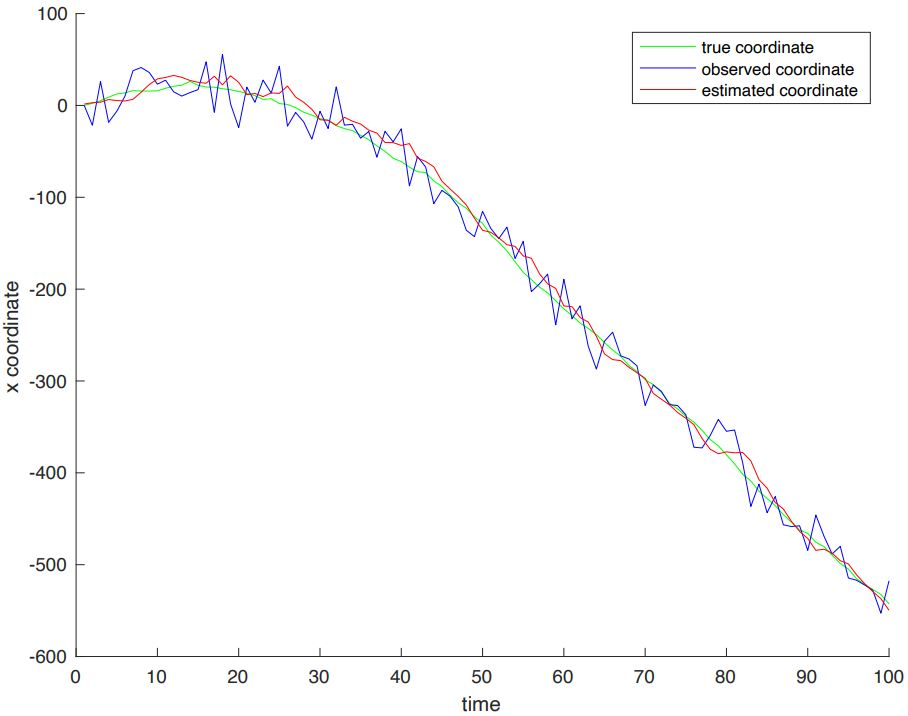

**Suggestion**: when implementing your Kalman filter, you will have to choose initial values for **$\mu_{t}$** and **$\Sigma_{t}$**. Provided that you do not make very unreasonable assumptions, the Kalman filter will update those estimates from observed data, so the initial choices are not very critical.

Test your Kalman filter modifying the values of some of the parameters, including standard deviations **$\sigma_{Q}$** and **$\sigma_{R}$**, initial values for **$\mu_{t}$** and **$\Sigma_{t}$** and the value of **$\Delta$**.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

!pip install ndjson

Mounted at /content/gdrive


In [ ]:
import ndjson
import pandas as pd
import numpy as np

#Dataset origin: https://paperswithcode.com/dataset/trajnet-1
#The crowds_students001 file is loaded, and formatted as a list of numpy vectors

with open('/content/gdrive/MyDrive/cl4/crowds_students001_trackonly.ndjson') as f:
  data = ndjson.load(f)

p='-1' #This variable is used to keep track of the current person's ID in the loop.

person_dict = [] #will be used to store the trajectory data for each person.

for ii in range(len(data)):
  if(p!=data[ii]['track']['p']):
    p=data[ii]['track']['p']
    person_dict.append([])
  person_dict[p].append((data[ii]['track']['x'],data[ii]['track']['y']))

  #It iterates through the data loaded from the NDJSON file. If the current person's ID (p) is different from the person's ID in the current data point, it means the loop has moved to a new person's trajectory. In that case, it appends an empty list to person_dict to start collecting the trajectory data for the new person

person_dict_numpy = []
for ii in range(148):
  person_dict_numpy.append(np.array(person_dict[ii], dtype=float)) #processes the collected trajectory data by converting it into a list of numpy arrays

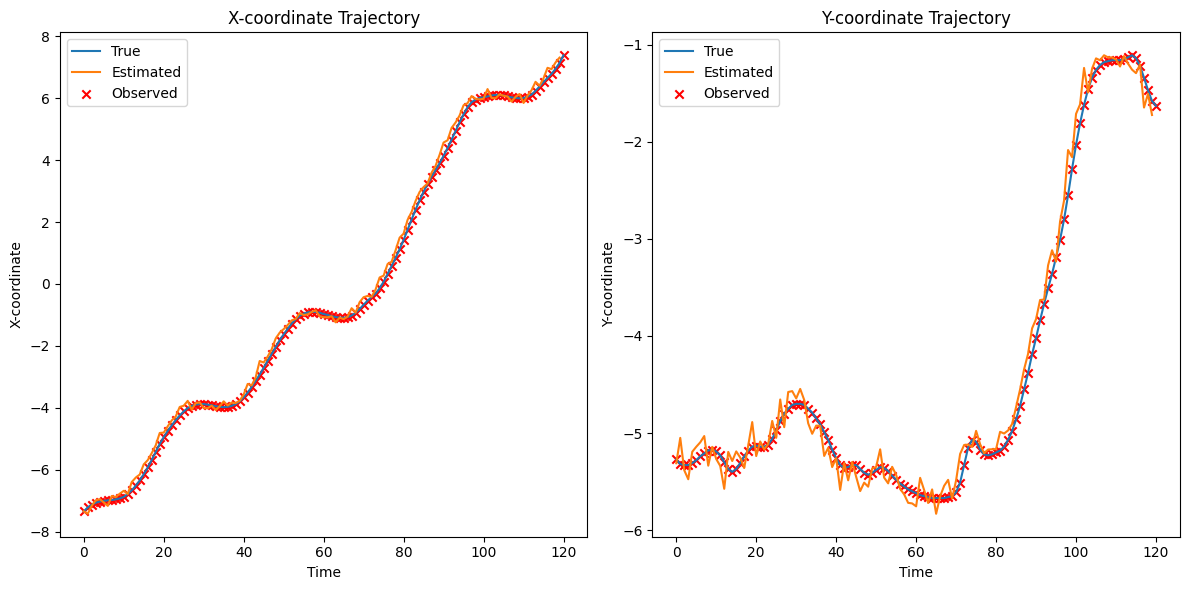

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Implement the kalman filter as a function using the numpy library, the matrix products can be done using the np.dot function
# The matrix inversion can be done using the np.linalg.inv

def kalman_filter(y, mu_tmin1, sigma_tmin1, A, C, Q, R):

  # Predict the state at the next time step
  mu_pred=np.dot (A , mu_tmin1)
  sigma_pred = np.dot(np.dot(A, sigma_tmin1), A.T)+ Q

  # Calculate the Kalman gain
  K=np.dot(np.dot(sigma_pred , C,T), np.linalg.inv(np.dot(np.dot (C , sigma_pred), C,T)+ R ))

  # Update the estimate of the state
  mu_est = mu_pred + np.dot (K , y - np.dot (C, mu_pred))
  sigma_est = np.dot((np.eye(len(mu_tmin1))- np.dot(K, C)), sigma_pred)

  return mu_est, sigma_est

true_positions = person_dict_numpy[100] #choose a single trajectory by taking an element of the list person_dict_numpy, select a random index between 0 and 148

#Define parameter delta
Delta = 1.5

A = np.array([[1, 0, Delta, 0],
              [0, 1, 0, Delta],
              [0, 0, 1, 0],
              [0, 0, 0, 1]])


# Define the measurement matrix
C = np.array([[1, 0, 0, 0],  # relate the true state vector to the observed measurements.
              [0, 1, 0, 0]]) # y is measured directly

# Set the standard deviation of the measurement noise

sigma_R = 0.1
sigma_Q = 1.0

# Define the process noise covariance matrix
Q = (sigma_Q**2) * np.eye(4)

#In this code, np.eye(4) creates a 4x4 identity matrix, and (sigma_Q**2) scales it by the square of the process noise standard deviation. This matrix represents the covariance of the process noise and is used in the Kalman filter prediction step to account for the uncertainty in the object's motion between time steps.

# Define the measurement noise covariance matrix
R = (sigma_R**2)*np.eye(2)

# Set the initial state and covariance
mu_0 = np.array([0, 0, Delta, Delta])
sigma_0 = np.eye(4)

# Iterate over the observed coordinates

for t in range(1,len(true_positions)):
  # Get the observed coordinates at time t
  # Note: the observed position is simulated by adding gaussian noise to the true_positions
  y = true_positions[t] + np.random.normal(0,sigma_R,2)

  #apply the kalman filter on the observed coordinates

# Initialize the list to store estimated positions
estimated_positions = []

# Apply the Kalman filter on the observed coordinates
for t in range(1, len(true_positions)):
    # Get the observed coordinates at time t
    # Note: the observed position is simulated by adding Gaussian noise to the true_positions
    y = true_positions[t] + np.random.normal(0, sigma_R, 2)

    # Kalman filter prediction step
    mu_pred = np.dot(A, mu_0)
    sigma_pred = np.dot(np.dot(A, sigma_0), A.T) + Q

    # Kalman filter update step
    K = np.dot(np.dot(sigma_pred, C.T), np.linalg.inv(np.dot(np.dot(C, sigma_pred), C.T) + R))
    mu_est = mu_pred + np.dot(K, y - np.dot(C, mu_pred))
    sigma_est = np.dot((np.eye(len(mu_0)) - np.dot(K, C)), sigma_pred)

    # Update mu_0 and sigma_0 for the next iteration
    mu_0 = mu_est
    sigma_0 = sigma_est

    # Append the estimated positions to the list
    estimated_positions.append(np.array([mu_est[0], mu_est[1]]))

# Convert the list of estimated positions to a numpy array
estimated_positions = np.array(estimated_positions)

# ... (The rest of your plotting code)


# Plot the results
plt.figure(figsize=(12, 6))

# Plot true positions, observed positions, and estimated positions (x-coordinate)
plt.subplot(1, 2, 1)
plt.plot(true_positions[:, 0], label='True')
plt.plot(estimated_positions[:, 0], label='Estimated')
plt.scatter(np.arange(len(true_positions)), true_positions[:, 0], label='Observed', c='r', marker='x')
plt.xlabel('Time')
plt.ylabel('X-coordinate')
plt.legend()
plt.title('X-coordinate Trajectory')

# Plot true positions, observed positions, and estimated positions (y-coordinate)
plt.subplot(1, 2, 2)
plt.plot(true_positions[:, 1], label='True')
plt.plot(estimated_positions[:, 1], label='Estimated')
plt.scatter(np.arange(len(true_positions)), true_positions[:, 1], label='Observed', c='r', marker='x')
plt.xlabel('Time')
plt.ylabel('Y-coordinate')
plt.legend()
plt.title('Y-coordinate Trajectory')

plt.tight_layout()
plt.show()